In [1]:
import seaborn as sns
import pandas as pd
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [38]:
filename_description_dict = {'idle.data': 'Idle (C-States enabled)',
                             'sqrt.data': 'Low power loop (sqrtsd)',
                             'firestarter_register.data': 'FIRESTARTER, no cache accesses',
                             'firestarter_cache_l2.data': 'FIRESTARTER, L1/L2 accesses',
                             'firestarter_cache.data': 'FIRESTARTER, L1/L2/L3 accesses',
                             'firestarter_ram.data': 'FIRESTARTER, L1/L2/L3/mem accesses',
                             'firestarter_cuda.data': 'FIRESTARTER, L1/L2/L3/mem+GPGPU'}
folder_description_dict = {'haswell': 'Haswell\ncompute\nnode',
                           'gpu2': 'Haswell\ncompute\nnode\nwith\nGPGPU'}
VALUE = 'Power [W]'

In [39]:
def strip_or_change_dtype(lst):
    for i in range(len(lst)):
        lst[i] = lst[i].strip('"')
        try:
            lst[i] = int(lst[i])
        except:
            try:
                lst[i] = float(lst[i])
            except:
                pass
    return lst

In [40]:
path = 'datafiles'
folders = listdir(path)

plot_df = pd.DataFrame()

for folder in folders:
    files = listdir(join(path, folder))
    for file, filename in zip(map(lambda f: open(join(path, folder, f), 'r'), files), files):
        if filename.startswith('firestarter_'):
            csv = file.read().split('\n')[-7:-1]
        else:
            csv = file.read().split('\n')[-3:-1]
        csv = list(map(lambda s: s.split(','), csv))
        keys, data = csv[0], list(map(strip_or_change_dtype, csv[1:]))
        df = pd.DataFrame()
        for values in data:
            df = df.append(dict(zip(keys, values)), ignore_index=True)
        if filename.startswith('firestarter_'):
            value, = df[df['metric'] == 'metricq']['average'].to_list()
        else:
            value, = df['average'].to_list()
        plot_df = plot_df.append({'name': filename_description_dict[filename], folder_description_dict[folder]: value}, ignore_index=True)

plot_df = plot_df.set_index('name').min(level=0).sort_values(folder_description_dict['gpu2'])

plot_df

,Haswell\ncompute\nnode\nwith\nGPGPU,Haswell\ncompute\nnode
name,,
Idle (C-States enabled),198.174,79.7976
Low power loop (sqrtsd),264.261,150.0690
"FIRESTARTER, no cache accesses",301.958,188.6280
"FIRESTARTER, L1/L2 accesses",361.125,244.7050
"FIRESTARTER, L1/L2/L3 accesses",435.042,310.6970
"FIRESTARTER, L1/L2/L3/mem accesses",460.000,333.5980
"FIRESTARTER, L1/L2/L3/mem+GPGPU",1083.170,NaN


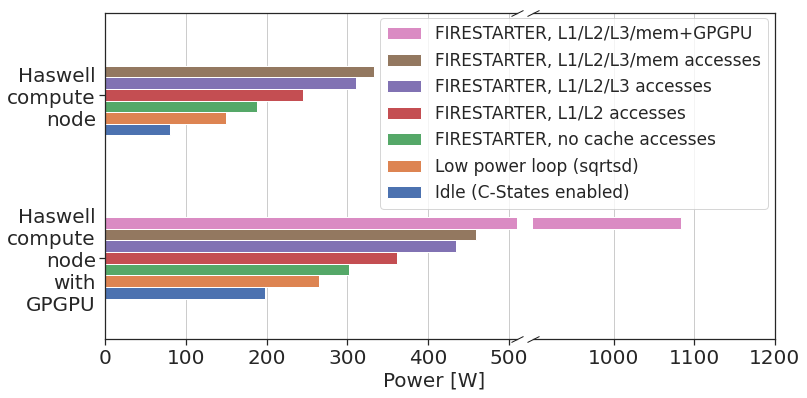

In [41]:
sns.set()
sns.set_style('ticks')

fontsize = 20

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[510, 1200-900.2], wspace=0.05)

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)

p1 = plot_df.T.plot(kind='barh', ax=ax1)
ax1.set_xlabel(VALUE, x=0.8, fontsize=fontsize)
p1.set_xlim(0, 510)
p1.legend().set_visible(False)

p2 = plot_df.T.plot(kind='barh', ax=ax2)
#p2.set(xlabel=VALUE)
p2.set_xlim(900.2, 1200)
#p2.legend().set_visible(False)

ax2.yaxis.set_ticks([])

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
#leg = p.legend()
#leg.set(title=None)
ax1.grid(b=True, axis='x', linestyle='-')
ax2.grid(b=True, axis='x', linestyle='-')
ax2.legend(reversed(ax2.legend().legendHandles), reversed(list(map(lambda t: t._text, ax2.legend().texts))), loc='lower right', bbox_to_anchor=(.97, .4), borderaxespad=0, fontsize=17)
ax1.tick_params(axis='both', labelsize=fontsize)
ax2.tick_params(axis='both', labelsize=fontsize)
plt.savefig('../../paper/fig/taurus_gpu2_power.pdf', bbox_inches='tight')